In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import torch
import sys
import numpy as np

sys.path.insert(0, '../')
from utils.Tracking import Tracking
from utils.Critic import CriticNetwork
from utils.Actor import ActorNetwork
from utils.CAC import CAC

from tqdm import tqdm

In [2]:
success = 0
fails = 0
nb_tests = 20

matrice_simulation_rewards = list()

for i in tqdm(range(nb_tests)) : 
    env = Tracking()
    actor_network = ActorNetwork(
        nb_neurons = 12,
        action_space = env.action_space,
        observation_space = env.observation_space
    )
    critic_network = CriticNetwork(
        nb_neurons = 12,
        observation_space = env.observation_space
    )
    cac = CAC(
        learning_rate_critic = 0.01,
        learning_rate_actor = 0.01,
        discount_factor = 0.95,
        sigma = 0.1,
        nb_episode = 500,
        test_frequency = 1,
        env = env,
        actor_network = actor_network,
        critic_network = critic_network,
        verbose_mode = False
    )
    cac.learning()
    matrice_simulation_rewards.append(cac.list_rewards)
    
    state = env.reset()
    done = False
    nb_iter = 0
    while not done :
        state_t = torch.as_tensor(state , dtype=torch.float32)
        action =  cac.best_model(state_t).detach().numpy()
        new_state, reward, done = env.step(action)
        state = new_state
        nb_iter += 1
    
    if nb_iter == env.max_iteration :
        fails += 1
    else :
        success += 1    

100%|██████████████████████████████████████████| 20/20 [59:00<00:00, 177.03s/it]


In [6]:
print(f"nombre de succes : {success}")
print(f"nombre d'echecs : {fails}")
print(f"ratio : {success/(success+fails)*100}%")

nombre de succes : 15
nombre d'echecs : 5
ratio : 75.0%


In [3]:
def rewards_normalization(matrice_simulation_rewards) :
    dist_max = -200
    dist_min = 0
    arr = np.array(matrice_simulation_rewards)
    return 1 - ( arr / (dist_max - dist_min)).mean(axis=0)
l = rewards_normalization(matrice_simulation_rewards)

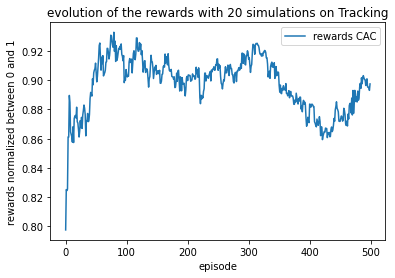

In [4]:
plt.figure()
plt.title(f"evolution of the rewards with {nb_tests} simulations on Tracking")
plt.xlabel("episode")
plt.ylabel("rewards normalized between 0 and 1")
plt.plot(l, label="rewards CAC")
plt.legend()
plt.show()

In [5]:
print("mean rewards : ",l.mean())
print("std rewards : ",l.std())

mean rewards :  0.8972239821947392
std rewards :  0.01866697126118402
